In [3]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime, timezone, timedelta
import os

id_dict = {}
path_dict = '/home/kisho_ucl/kisho_ws/warehouse_task_recognition/data/id_dict.txt'
with open(path_dict, "r") as file:
    for line in file:
        key, value = line.strip().split(": ")
        id_dict[int(key)] = int(value)
subid_dict = {value: key for key, value in id_dict.items()}



In [4]:
import torch
from torch.utils.data import Dataset

class IMUDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]


In [5]:
from copy import deepcopy
import os
import json


class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_state = None
        self.best_epoch = 0

    def __call__(self, epoch, val_loss, model):
        # 初回、または改善したとき
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.best_state = deepcopy(model.state_dict())
            self.best_epoch = epoch
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True



In [55]:
import numpy as np
import preprocess
import importlib
importlib.reload(preprocess)
from preprocess import load_session_trusco, window_split_trusco
from torch.utils.data import DataLoader, random_split
from dataclasses import dataclass

@dataclass
class ExperimentConfig:
    model_type: str           # "cnn-linear", "multi-trans"
    pretrain: bool            # SimCLR pretrain
    frozen: bool              # freeze encoder
    lr_type: str              # "uniform" or "layerwise" or "none" (when frozen)
    base_dir: str             # base directory to save results
    save_dir: str             # directory to save results
    seed: int = 0             # random seed

def build_loaders_for_subject(
    test_user,
    YDs,
    IDs,
    Hours,
    all_entries,
    config: ExperimentConfig
):

    X_train, y_train = [], []
    X_test,  y_test  = [], []

    for Year, Date in YDs:
        for ID in IDs:
            for h in Hours:

                if h not in all_entries or ID not in all_entries[h]:
                    continue

                imu, labels = load_session_trusco(ID, Year, Date, h)
                if imu is None:
                    continue

                # test_user 
                if ID == test_user:
                    X, y = window_split_trusco(
                        imu, labels,
                        window_size=256*20,
                        stride=256*1
                    )
                    valid = (y != -1)
                    X_test.append(X[valid])
                    y_test.append(y[valid])

                # train_user 
                else:
                    X, y = window_split_trusco(
                        imu, labels,
                        window_size=256*20,
                        stride=256*4
                    )
                    valid = (y != -1)
                    X_train.append(X[valid])
                    y_train.append(y[valid])

    # concat
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    X_test  = np.concatenate(X_test)
    y_test  = np.concatenate(y_test)

    # Dataset 
    train_dataset = IMUDataset(X_train, y_train)
    test_dataset  = IMUDataset(X_test,  y_test)

    # train を train/valid に分割 
    train_len = int(len(train_dataset) * (1 - 0.1))
    valid_len = len(train_dataset) - train_len

    train_ds, valid_ds = random_split(
        train_dataset,
        [train_len, valid_len],
        generator=torch.Generator().manual_seed(config.seed)
    )

    # DataLoader 
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size=16, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

    print(f"[test_user={test_user}] Train={len(train_ds)}, Valid={len(valid_ds)}, Test={len(test_dataset)}")

    return train_loader, valid_loader, test_loader


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import os
import json


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_class_weights(train_loader, num_classes):
    counts = torch.zeros(num_classes)

    for _, labels in train_loader:
        for c in range(num_classes):
            counts[c] += (labels == c).sum()

    total = counts.sum()
    counts[counts == 0] = 1  # 0割回避
    weights = total / (num_classes * counts)
    
    return weights                                                                                                                                                                                                                                                                               


# Train one epoch
def train_one_epoch(classifier, loader, optimizer, criterion):
    classifier.train()
    total_loss = 0
    total_n = 0

    for signals, labels in loader:
        signals = signals.to(device)
        labels  = labels.to(device)

        logits = classifier(signals)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(labels)
        total_n    += len(labels)

    return total_loss / total_n



# Evaluate
def evaluate(classifier, loader, criterion=None):
    classifier.eval()
    total_loss = 0
    total_n = 0

    Y, P = [], []

    with torch.no_grad():
        for signals, labels in loader:
            signals = signals.to(device)
            labels  = labels.to(device)

            logits = classifier(signals)
            preds  = logits.argmax(dim=1)

            Y.extend(labels.cpu().numpy())
            P.extend(preds.cpu().numpy())

            if criterion is not None:
                loss = criterion(logits, labels)
                total_loss += loss.item() * len(labels)
                total_n    += len(labels)

    if criterion is None:
        return Y, P, None
    else:
        return Y, P, total_loss / total_n

def record_results(test_user, y_true, y_pred,
                           results_dir="results_loso"):
    os.makedirs(results_dir, exist_ok=True)
    save_path = os.path.join(results_dir, f"{test_user}.json")

    result = {
        "user": test_user,
        "y_true": list(map(int, y_true)),
        "y_pred": list(map(int, y_pred))
    }
    with open(save_path, "w") as f:
        json.dump(result, f, indent=2)

    print(f"Saved: {save_path}")


In [8]:
# import models
# importlib.reload(models)
# from models import SimCLR_new, CNN_Encoder, TaskClassifier_Transformer, TaskClassifier_LSTM

# def build_model(model_type, use_pretrained=False, freeze_encoder=False):
#     """
#     model_type: 
#         "lstm" | "prelstm" | "transformer" | "pretransformer"
#     """

#     # 1. Pretrained Encoder (SimCLR)
#     pretrained_encoder = None
#     if use_pretrained or ("pre" in model_type):
#         sim = SimCLR_new(6, 256, 64, 128, 128, 4, 3, 64)
#         sim.load_state_dict(torch.load("/home/kisho_ucl/kisho_ws/deep_HAR/trusco/experiments/model/0511/imu_encoder_100.pth", map_location="cpu"))
#         pretrained_encoder = sim.encoder

#     # 2. CNN Encoder selection
#     if "pre" in model_type:
#         encoder = pretrained_encoder
#     else:
#         encoder = CNN_Encoder(6, 256, 64, 128)

#     # freeze の設定
#     if freeze_encoder:
#         for p in encoder.parameters():
#             p.requires_grad = False

#     # 3. Model selection

#     # ---------- LSTM ----------
#     if model_type == "cnn-lstm":
#         return TaskClassifier_LSTM(
#             encoder=encoder, hidden_dim=128, window_len=256, overlap=0.5,
#             lstm_hidden=128, lstm_layers=2, num_classes=3, freeze_encoder=False
#         )

#     if model_type == "precnn-lstm":
#         return TaskClassifier_LSTM(
#             encoder=encoder, hidden_dim=128, window_len=256, overlap=0.5,
#             lstm_hidden=128, lstm_layers=2, num_classes=3, freeze_encoder=True
#         )

#     # ---------- Transformer ----------
#     if model_type == "cnn-t":
#         return TaskClassifier_Transformer(
#             encoder=encoder, hidden_dim=128, window_len=256, overlap=0.5,
#             num_heads=4, num_layers=3, num_classes=3, freeze_encoder=False
#         )

#     if model_type == "precnn-t":
#         return TaskClassifier_Transformer(
#             encoder=encoder, hidden_dim=128, window_len=256, overlap=0.5,
#             num_heads=4, num_layers=3, num_classes=3, freeze_encoder=True
#         )


#     # ----------------------------------------------------
#     raise ValueError(f"Unknown model_type: {model_type}")


# def build_optimizer(model, model_type, freeze_encoder):
#     if freeze_encoder:
#            print("encoder -> frozen")
#            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#            return optimizer
    
#     else:
#         if "cnn-lstm" in model_type:
#             print("lr setting: encoder(1e-6), lstm(1e-4)")
#             optimizer = torch.optim.Adam([
#             {"params": model.encoder.parameters(),      "lr": 1e-6},
#             {"params": model.lstm.parameters(),  "lr": 1e-4, "weight_decay": 1e-4},
#             {"params": model.classifier.parameters(),   "lr": 1e-4, "weight_decay": 1e-4},
#             ])
#             return optimizer

#         if "cnn-t" in model_type:
#             print("lr setting: encoder(1e-6), transformer(1e-4)")
#             optimizer = torch.optim.Adam([
#             {"params": model.encoder.parameters(),      "lr": 1e-6},
#             {"params": model.transformer.parameters(),  "lr": 1e-4, "weight_decay": 1e-4},
#             {"params": model.classifier.parameters(),   "lr": 1e-4, "weight_decay": 1e-4},
#             ])
#             return optimizer

#     raise ValueError("Unknown model type in optimizer")


In [43]:
import models
importlib.reload(models)
from models import SimCLR_new, CNN_Encoder, TaskClassifier_Transformer, TaskClassifier_LSTM
from dataclasses import dataclass

@dataclass
class ExperimentConfig:
    model_type: str           # "cnn-linear", "multi-trans"
    pretrain: bool            # SimCLR pretrain
    frozen: bool              # freeze encoder
    lr_type: str              # "uniform" or "layerwise" or "none" (when frozen)
    base_dir: str             # base directory to save results
    save_dir: str             # directory to save results
    seed: int = 0             # random seed

def build_model(config: ExperimentConfig):
    """
    config.model_type : "cnn-linear" or "multi-trans"
    config.pretrain   : True/False
    config.frozen     : True/False
    """

    # --- 1. Encoder 作成 ---
    if config.pretrain:
        sim = SimCLR_new(6, 256, 64, 128, 128, 4, 3, 64)
        sim.load_state_dict(torch.load(
            "/home/kisho_ucl/kisho_ws/deep_HAR/trusco/experiments/model/0511/imu_encoder_100.pth",
            map_location="cpu"
        ))
        encoder = sim.encoder
        print("Loaded pretrained encoder.")
    else:
        encoder = CNN_Encoder(6, 256, 64, 128)
        print("Created new encoder.")

    # --- Freeze設定 ---
    if config.frozen:
        for p in encoder.parameters():
            p.requires_grad = False

        print("Encoder is frozen.")
    else:
        print("Encoder is trainable.")

    # --- 2. Model selection ---
    if config.model_type == "cnn-linear":
        model = TaskClassifier_LSTM(   # ← linear head なら別クラスでもOK
            encoder=encoder,
            hidden_dim=128,
            window_len=256,
            overlap=0.5,
            lstm_hidden=128,
            lstm_layers=2,
            num_classes=3,
            freeze_encoder=config.frozen
        )
        return model

    elif config.model_type == "multi-trans":
        model = TaskClassifier_Transformer(
            encoder=encoder,
            hidden_dim=128,
            window_len=256,
            overlap=0.5,
            num_heads=4,
            num_layers=3,
            num_classes=3,
            freeze_encoder=config.frozen
        )
        return model

    else:
        raise ValueError(f"Unknown model_type: {config.model_type}")
    
def build_optimizer(model, config: ExperimentConfig):

    # =============================
    # 1. encoder を固定する場合
    # =============================
    if config.frozen:
        print("Optimizer: frozen encoder → uniform LR 1e-4")
        params = [p for p in model.parameters() if p.requires_grad]
        return torch.optim.Adam(params, lr=1e-4)


    # =============================
    # 2. uniform LR
    # =============================
    if config.lr_type == "uniform":
        print("Optimizer: uniform lr=1e-4")
        return torch.optim.Adam(model.parameters(), lr=1e-4)


    # =============================
    # 3. layer-wise LR
    # =============================
    elif config.lr_type == "layerwise":

        encoder_lr = 1e-5
        head_lr = 1e-4

        if isinstance(model, TaskClassifier_Transformer):
            print("Optimizer: layerwise (Transformer)")
            return torch.optim.Adam([
                {"params": model.encoder.parameters(),      "lr": encoder_lr},
                {"params": model.transformer.parameters(),  "lr": head_lr}, #out weight decay
                {"params": model.classifier.parameters(),   "lr": head_lr},
            ])

        elif isinstance(model, TaskClassifier_LSTM):
            print("Optimizer: layerwise (LSTM)")
            return torch.optim.Adam([
                {"params": model.encoder.parameters(),      "lr": encoder_lr},
                {"params": model.lstm.parameters(),         "lr": head_lr}, # out weight decay
                {"params": model.classifier.parameters(),   "lr": head_lr},
            ])
        else:
            raise ValueError("Unknown model architecture for layerwise LR")

    else:
        raise ValueError(f"Unknown lr_type {config.lr_type}")




In [44]:
import models
importlib.reload(models)
from models import SimCLR_new, CNN_Encoder, TaskClassifier_Transformer, TaskClassifier_LSTM
from dataclasses import dataclass
import random

@dataclass
class ExperimentConfig:
    model_type: str           # "cnn-linear", "multi-trans"
    pretrain: bool            # SimCLR pretrain
    frozen: bool              # freeze encoder
    lr_type: str              # "uniform" or "layerwise" or "none" (when frozen)
    base_dir: str             # base directory to save results
    save_dir: str           # directory to save results
    seed: int = 0             # random seed

# Reset random seeds
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# LOSO
def run_loso_one(
        train_loader, valid_loader, test_loader,
        weight_tensor, test_user="UNKNOWN",
        max_epochs=30, patience=5,
        config: ExperimentConfig = None):

    # Set random seed
    set_seed(config.seed)

    # モデル構築
    classifier = build_model(config).to(device)
    optimizer = build_optimizer(classifier, config)

    weight_tensor = weight_tensor.to(device)
    criterion = nn.CrossEntropyLoss(weight=weight_tensor)


    # Early stopping
    early_stopper = EarlyStopping(patience=patience)

    # Training loop
    for epoch in range(1, max_epochs + 1):

        train_loss = train_one_epoch(classifier, train_loader, optimizer, criterion)
        _, _, valid_loss = evaluate(classifier, valid_loader, criterion)
        Y_tmp, P_tmp, test_loss = evaluate(classifier, test_loader, criterion)
        f1_tmp = f1_score(Y_tmp, P_tmp, average="weighted")

        print(
            f"[Epoch {epoch}/{max_epochs}] "
            f"Train={train_loss:.4f} | "
            f"Valid={valid_loss:.4f} | "
            f"Test={test_loss:.4f} | F1={f1_tmp:.4f}"
        )

        # early stopping check
        early_stopper(epoch, valid_loss, classifier)
        if early_stopper.early_stop:
            print("Early stopping.")
            break

    # Load best model
    classifier.load_state_dict(early_stopper.best_state)

    Y, P, _ = evaluate(classifier, test_loader, criterion)
    final_f1 = f1_score(Y, P, average="weighted")

    print(f"[{test_user}] Final F1 = {final_f1:.4f} | BestEpoch={early_stopper.best_epoch}")

    record_results(test_user, Y, P, results_dir=config.save_dir)

    return final_f1, Y, P, classifier

In [67]:
YDs = [[2024,1003]]
Hours = range(7,18,1)
IDs = range(0,39,1)

all_entries = {
    8: [1], 
    9: [21],  
    10: [13],                
    11: [2,6,9,23,27,36,16]  #
}

configs = [
    # ────────────── No Pretrain ──────────────
    ExperimentConfig("multi-trans", False, False, "uniform",   "", "results_loso/T1_noPT_uniform"),
    ExperimentConfig("multi-trans", False, False, "layerwise", "", "results_loso/T2_noPT_layerwise"),

    # ────────────── Pretrain + Frozen ──────────────
    ExperimentConfig("multi-trans", True,  True,  "none",      "", "results_loso/T3_PT_frozen"),

    # ────────────── Pretrain + Fine-tune ──────────────
    ExperimentConfig("multi-trans", True,  False, "uniform",   "", "results_loso/T4_PT_ft_uniform"),
    ExperimentConfig("multi-trans", True,  False, "layerwise", "", "results_loso/T5_PT_ft_layerwise"),
]


use_pretrained_model=True
freeze_encoder = False

if use_pretrained_model:
    print("LOOCV : PreCNN-Transformer")
else:
    print("LOOCV : CNN-Transformer")


for i in range(5):
    print(f"=== Experiment {i+1}/5 ===")
    print(configs[i])

    for test_hour, subjects in all_entries.items():
        for test_subject in subjects:

            train_loader, valid_loader, test_loader = build_loaders_for_subject(
                test_user=test_subject,
                YDs=YDs,
                IDs=IDs,
                Hours=Hours,
                all_entries=all_entries,
                config=configs[i]
            )

            num_classes = 3
            weight_tensor = compute_class_weights(train_loader, num_classes)
            print("Class weights:", weight_tensor.numpy())

            f1, Y, P, classifier = run_loso_one(
                train_loader, valid_loader, test_loader,
                weight_tensor,
                test_user=test_subject,
                max_epochs=30, patience=5,
                config=configs[i]
            )


            print(f"Subject={test_subject} F1={f1:.4f}")


LOOCV : PreCNN-Transformer
=== Experiment 1/5 ===
ExperimentConfig(model_type='multi-trans', pretrain=False, frozen=False, lr_type='uniform', base_dir='', save_dir='results_loso/T1_noPT_uniform', seed=0)
[test_user=1] Train=1742, Valid=194, Test=890
Class weights: [0.72043014 1.067402   1.4812925 ]
Created new encoder.
Encoder is trainable.
Optimizer: uniform lr=1e-4
[Epoch 1/30] Train=0.6589 | Valid=0.3534 | Test=1.0952 | F1=0.5229
[Epoch 2/30] Train=0.3854 | Valid=0.1942 | Test=0.8988 | F1=0.6330
[Epoch 3/30] Train=0.2972 | Valid=0.1108 | Test=1.2860 | F1=0.5319


KeyboardInterrupt: 

In [34]:
import os
import json
import numpy as np
from sklearn.metrics import f1_score

def compute_weighted_f1(results_dir, num_classes=3):
    files = sorted(os.listdir(results_dir))

    all_y = []
    all_p = []

    for fname in files:
        if not fname.endswith(".json"):
            continue

        with open(os.path.join(results_dir, fname)) as fp:
            res = json.load(fp)

        y_true = np.array(res["y_true"])
        y_pred = np.array(res["y_pred"])

        all_y.extend(y_true)
        all_p.extend(y_pred)

    all_y = np.array(all_y)
    all_p = np.array(all_p)

    f1_weighted = f1_score(all_y, all_p, average="weighted")

    return f1_weighted

root = "results_loso"
summary = {}

for exp in sorted(os.listdir(root)):
    exp_dir = os.path.join(root, exp)
    if not os.path.isdir(exp_dir):
        continue

    f1 = compute_weighted_f1(exp_dir)
    summary[exp] = f1

summary



{'T1_noPT_uniform': 0.790628423393329,
 'T2_noPT_layerwise': 0.8478091575375071,
 'T3_PT_frozen': 0.8868927264355121,
 'T4_PT_ft_uniform': 0.8745431671037374,
 'T5_PT_ft_layerwise': 0.899495744991978}

# 5-times Ablation

In [68]:
configs = [
    # ────────────── No Pretrain ──────────────
    ExperimentConfig("multi-trans", False, False, "uniform",   "T1_noPT_uniform", ""),
    ExperimentConfig("multi-trans", False, False, "layerwise", "T2_noPT_layerwise", ""),

    # ────────────── Pretrain + Frozen ──────────────
    ExperimentConfig("multi-trans", True,  True,  "none",      "T3_PT_frozen", ""),

    # ────────────── Pretrain + Fine-tune ──────────────
    ExperimentConfig("multi-trans", True,  False, "uniform",   "T4_PT_ft_uniform", ""),
    ExperimentConfig("multi-trans", True,  False, "layerwise", "T5_PT_ft_layerwise", ""),
]


seeds = [0, 1, 2, 3, 4]   # ← 5回の試行


for seed in seeds:   # ← ★ 最外側に seed
    print(f"\n=========== SEED {seed} ===========")

    for cfg in configs:  # ← 次に variant（T1〜T5）
        print("===================================")
        print(f" Variant: {cfg.base_dir}")
        print("===================================")

        # cfg に seed と save_dir を設定
        cfg.seed = seed
        cfg.save_dir = f"results_loso/seed{seed}/{cfg.base_dir}"

        for test_hour, subjects in all_entries.items():
            for test_subject in subjects:

                # ---- Seed 固定 ----
                set_seed(seed)

                # ---- Loaders ----
                train_loader, valid_loader, test_loader = build_loaders_for_subject(
                    test_user=test_subject,
                    YDs=YDs,
                    IDs=IDs,
                    Hours=Hours,
                    all_entries=all_entries,
                    config=cfg
                )

                # ---- Weight ----
                num_classes = 3
                weight_tensor = compute_class_weights(train_loader, num_classes)

                # ---- Train ----
                f1, Y, P, classifier = run_loso_one(
                    train_loader, valid_loader, test_loader,
                    weight_tensor,
                    test_user=test_subject,
                    max_epochs=30, patience=5,
                    config=cfg
                )

                print(f" Seed={seed}, Subject={test_subject}, F1={f1:.4f}")



=========== SEED 0 ===========
 Variant: T1_noPT_uniform
[test_user=1] Train=1742, Valid=194, Test=890
Created new encoder.
Encoder is trainable.
Optimizer: uniform lr=1e-4
[Epoch 1/30] Train=0.6589 | Valid=0.3534 | Test=1.0952 | F1=0.5229
[Epoch 2/30] Train=0.3854 | Valid=0.1942 | Test=0.8988 | F1=0.6330
[Epoch 3/30] Train=0.2972 | Valid=0.1108 | Test=1.2860 | F1=0.5319
[Epoch 4/30] Train=0.2189 | Valid=0.0855 | Test=1.3712 | F1=0.5792
[Epoch 5/30] Train=0.1954 | Valid=0.0925 | Test=1.5105 | F1=0.5400
[Epoch 6/30] Train=0.1502 | Valid=0.0848 | Test=1.4468 | F1=0.5765
[Epoch 7/30] Train=0.1379 | Valid=0.2096 | Test=1.7614 | F1=0.5254
[Epoch 8/30] Train=0.1340 | Valid=0.0627 | Test=1.0885 | F1=0.6662
[Epoch 9/30] Train=0.1365 | Valid=0.0593 | Test=1.6042 | F1=0.5760
[Epoch 10/30] Train=0.1278 | Valid=0.0483 | Test=1.6698 | F1=0.5338
[Epoch 11/30] Train=0.1014 | Valid=0.1212 | Test=0.8774 | F1=0.7155
[Epoch 12/30] Train=0.0986 | Valid=0.0527 | Test=1.4590 | F1=0.5767
[Epoch 13/30] Train

In [71]:
import os, json, numpy as np
from sklearn.metrics import f1_score

def load_variant_scores(root="results_loso"):
    scores = {}  # {variant: [f1_seed0, f1_seed1, ...]}

    for seed in sorted(os.listdir(root)):
        seed_dir = os.path.join(root, seed)
        if not os.path.isdir(seed_dir): 
            continue

        for variant in sorted(os.listdir(seed_dir)):
            var_dir = os.path.join(seed_dir, variant)
            if not os.path.isdir(var_dir):
                continue

            # Score list init
            if variant not in scores:
                scores[variant] = []

            # 各被験者JSONをseed単位で統合してF1を1つ算出
            y_all, p_all = [], []
            for fname in sorted(os.listdir(var_dir)):
                if not fname.endswith(".json"): 
                    continue
                with open(os.path.join(var_dir, fname)) as fp:
                    r = json.load(fp)
                y_all += r["y_true"]
                p_all += r["y_pred"]

            if len(y_all)==0:
                scores[variant].append(None)
            else:
                f1w = f1_score(np.array(y_all), np.array(p_all), average="weighted")
                scores[variant].append(f1w)

    return scores

scores = load_variant_scores(root="results_loso_1202")

def summarize_scores(scores):
    summary = {}
    for variant, vals in scores.items():
        vs = [v for v in vals if v is not None]
        summary[variant] = {
            "mean_f1": np.nanmean(vs),
            "std_f1":  np.nanstd(vs),
            "num_seeds": len(vs)
        }
    return summary

summary = summarize_scores(scores)



| Variant | Mean(F1) | Std(F1) | #Seeds |
|---|---|---|---|
| T1_noPT_uniform | 0.810 | 0.011 | 5 |
| T2_noPT_layerwise | 0.839 | 0.022 | 5 |
| T3_PT_frozen | 0.880 | 0.009 | 5 |
| T4_PT_ft_uniform | 0.879 | 0.006 | 5 |
| T5_PT_ft_layerwise | 0.880 | 0.007 | 5 |



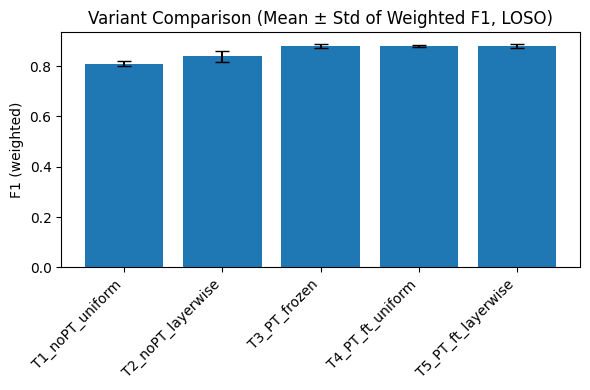

In [72]:
import pandas as pd
df = pd.DataFrame(
    [(k, v["mean_f1"], v["std_f1"], v["num_seeds"]) for k,v in summary.items()],
    columns=["variant","mean_f1","std_f1","num_seeds"]
)

md = "| Variant | Mean(F1) | Std(F1) | #Seeds |\n"
md+= "|---|---|---|---|\n"
for _,r in df.iterrows():
    md+= f"| {r.variant} | {r.mean_f1:.3f} | {r.std_f1:.3f} | {int(r.num_seeds)} |\n"
print(md)

import matplotlib.pyplot as plt

variants = df["variant"]
means    = df["mean_f1"]
stds     = df["std_f1"]

x = np.arange(len(variants))

plt.figure(figsize=(6,4))

plt.bar(x, means, yerr=stds, capsize=5)  # ← 標準偏差をエラーバーに
plt.xticks(x, variants, rotation=45, ha="right")
plt.ylabel("F1 (weighted)")
plt.title("Variant Comparison (Mean ± Std of Weighted F1, LOSO)")
plt.tight_layout()
plt.show()


  LOSO RESULTS SUMMARY

[1] Mean per-user weighted F1
    → 0.8308655050861338

[2] Weighted F1 (all data concatenated)
    → 0.8433786427210841

[3] Macro F1 (all data concatenated)
    → 0.829155236508296

Per-user detail:
  1: 0.7145
  13: 0.8407
  16: 0.6132
  2: 0.7188
  21: 0.7323
  23: 1.0000
  27: 0.9254
  36: 0.9865
  6: 0.9826
  9: 0.7946


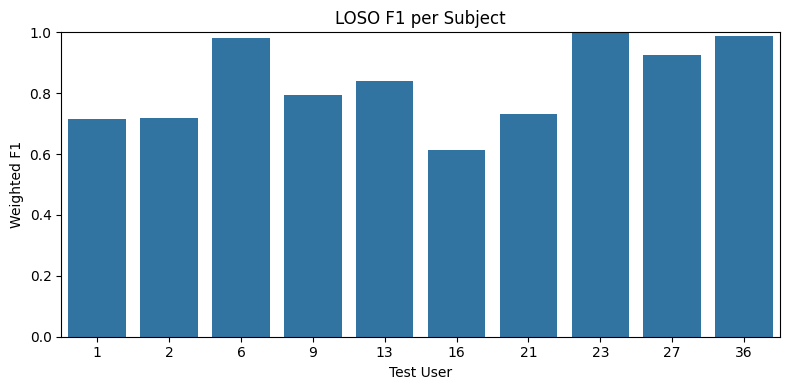

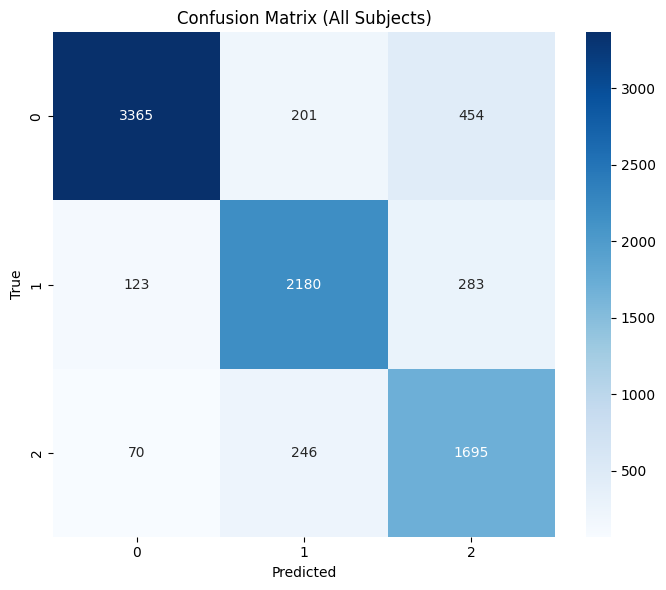

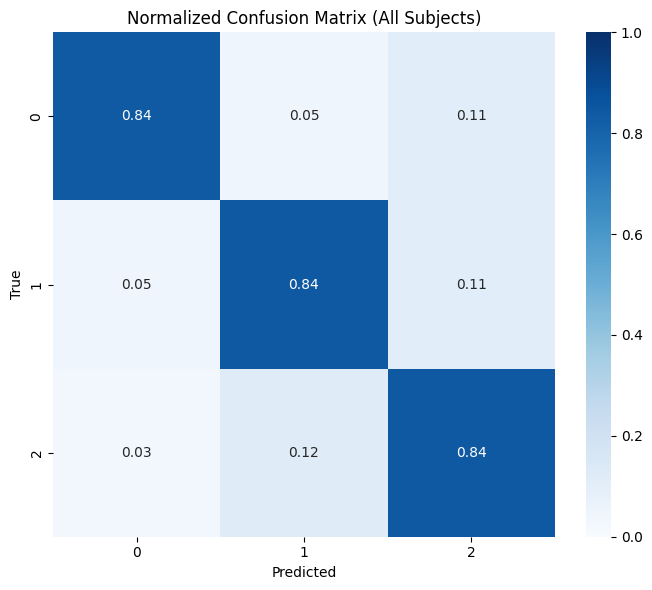

In [ ]:
import os
import json
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

results_dir = "./results_loso"
files = sorted(os.listdir(results_dir))

num_classes = 3

# per-user weighted F1 
f1_per_user = {}
all_y = []
all_p = []

for fname in files:
    with open(os.path.join(results_dir, fname)) as fp:
        res = json.load(fp)

    user = res["user"]
    y_true = np.array(res["y_true"])
    y_pred = np.array(res["y_pred"])

    f1_u = f1_score(y_true, y_pred, average="weighted")
    f1_per_user[user] = f1_u

    all_y.extend(y_true)
    all_p.extend(y_pred)

# all-user weighted F1
all_y = np.array(all_y)
all_p = np.array(all_p)

f1_all_weighted = f1_score(all_y, all_p, average="weighted")
f1_all_macro    = f1_score(all_y, all_p, average="macro")

# 3. overal confusion matrix
cm = confusion_matrix(all_y, all_p, labels=np.arange(num_classes))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)

# results
print("============================================")
print("  LOSO RESULTS SUMMARY")
print("============================================")
print("\n[1] Mean per-user weighted F1")
print("    →", np.mean(list(f1_per_user.values())))

print("\n[2] Weighted F1 (all data concatenated)")
print("    →", f1_all_weighted)

print("\n[3] Macro F1 (all data concatenated)")
print("    →", f1_all_macro)

print("\nPer-user detail:")
for u, f1 in f1_per_user.items():
    print(f"  {u}: {f1:.4f}")


# plot f1 distribution
plt.figure(figsize=(8,4))
sns.barplot(x=list(f1_per_user.keys()), y=list(f1_per_user.values()))
plt.ylim(0,1)
plt.xlabel("Test User")
plt.ylabel("Weighted F1")
plt.title("LOSO F1 per Subject")
plt.tight_layout()
plt.show()

# plot confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (All Subjects)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (All Subjects)")
plt.tight_layout()
plt.show()
